In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import erf

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# physical constants
G_const = 6.67430e-11
R_const = 8.314
M_sun   = 1.989e30
AU      = 1.495979e+11
R_earth = 6.371e6

In [15]:
# system constants 
T_mantle    = 3000.0
sma         = 1.0 * AU
M_st        = 0.1 * M_sun
R_pl        = 1.0 * R_earth
stiff_eff   = 1.71e4*1e9    # beta_st
ecc         = 0.1 
shear_ref   = 6.24e4        # mu_ref
shear_act   = 2e5           # A_mu or E_mu 
visc_ref    = 6e7           # nu_0
visc_act    = 3e5           # A_nu or E_nu
zeta        = 5e-4          # zeta
melt        = 0.5
melt_ref    = 0.8           # phi_star
gamma_ph    = 6.0           # gamma_ph
delta_ph    = 6.0           # delta_ph
B_melt      = 2.5           # B
rho_m       = 4800.0        # mantle density

In [16]:
def eval_tidefreq():
    # Evaluate tidal frequency (=mean motion)

    out = np.sqrt(G_const * M_st / sma**3)

    return out 

In [17]:
def eval_phase():
    
    # Equation 9
    phi = melt/melt_ref
    _arg = np.sqrt(np.pi) * phi * (1.0 + phi**gamma_ph)  / (2 * (1-zeta))
    F = (1-zeta) * erf(_arg)

    # Equation 8
    out = (1 + phi**delta_ph) / ((1 + F)**(B_melt*gamma_ph))

    return out

In [18]:
def eval_shear():

    eps_phase = eval_phase()

    # Equation 7 
    out = shear_ref
    out *= np.exp(shear_act/(R_const*T_mantle))
    out /= eps_phase

    return out 

In [19]:
def eval_effvisc():

    eps_phase = eval_phase()

    # Equation 6 
    out = visc_ref
    out *= np.exp(visc_act/(R_const*T_mantle))
    out /= eps_phase

    return out 

In [20]:
def eval_k2(shear=None):
    # Equation 3 

    _shear = shear if bool(shear) else eval_shear()

    denom = 1 + (19.0/2.0)*(_shear/stiff_eff)

    return 3.0 / (2 * denom) 

In [21]:
def eval_dynvisc():
    # See inline equation just after Equation 6
    return eval_effvisc() * rho_m

In [22]:
def eval_Imk2(visc=None, shear=None):
    # Equation 4 * (-1.0)

    tidefreq = eval_tidefreq()
    _shear = shear if bool(shear) else eval_shear()
    _dynvisc = visc if bool(visc) else eval_dynvisc()

    # numerator 
    numer = -57.0
    numer *= _dynvisc  # eta 
    numer *= tidefreq  # omega  

    # denominator
    denom = 4.0 
    denom *= stiff_eff   # beta_st
    denom *= 1.0 + ( (1.0 + 19*shear/(2*stiff_eff)) * _dynvisc * tidefreq / _shear )**2.0

    return numer/denom


In [23]:
def eval_Qfactor(visc=None, shear=None):
    # Equation 5 

    tidefreq = eval_tidefreq()
    _shear = shear if bool(shear) else eval_shear()
    _dynvisc = visc if bool(visc) else eval_dynvisc()

    return _dynvisc * tidefreq / _shear 

In [24]:
def eval_Qtidal_sync(visc=None, shear=None):

    Imk2 = eval_Imk2(visc=visc, shear=shear)

    # Equation 2
    out = -21.0/2.0
    out *= Imk2 
    out *= G_const**(3.0/2)
    out *= M_st**(5.0/2)
    out *= R_pl**(5.0)
    out *= ecc**(2.0)
    out *= sma**(-15/2.0)

    return out 

In [25]:
def eval_Qtidal_simple(visc=None, shear=None):

    Imk2 = -1.0 * eval_k2(shear=shear) / eval_Qfactor(visc=visc, shear=shear)

    # Equation 2
    out = -21.0/2.0
    out *= Imk2 
    out *= G_const**(3.0/2)
    out *= M_st**(5.0/2)
    out *= R_pl**(5.0)
    out *= ecc**(2.0)
    out *= sma**(-15/2.0)

    return out 

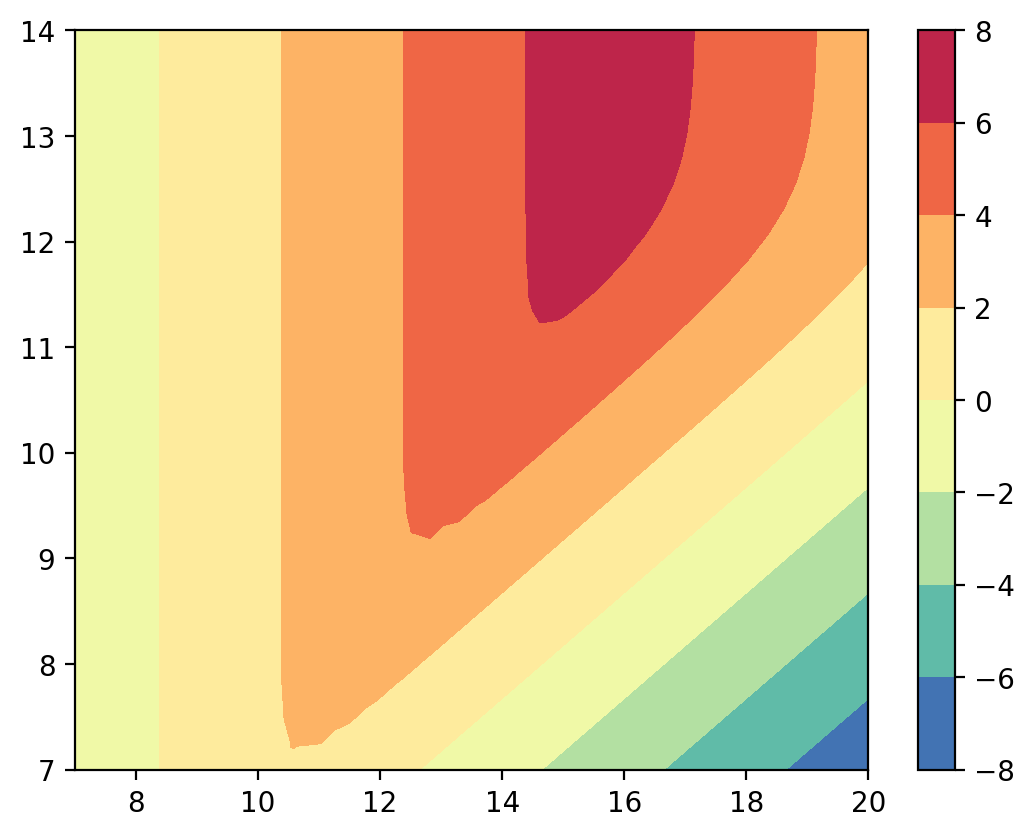

In [31]:
x_evl = np.logspace(7, 20, 30) # effective viscosity 
y_evl = np.logspace(7, 14, 30) # shear modulus 

z_arr = []
x_arr = []
y_arr = []

for x in x_evl:
    for y in y_evl: 

        z = eval_Qtidal_sync(visc=x*rho_m, shear=y)

        x_arr.append(np.log10(x))
        y_arr.append(np.log10(y))
        z_arr.append(np.log10(z))

fig,ax = plt.subplots(1,1)

sm = ax.tricontourf(x_arr, y_arr, z_arr, cmap='Spectral_r')
# sm = ax.scatter(x_arr, y_arr, c=z_arr, cmap='Spectral_r', s=30, marker='s')

fig.colorbar(sm)

plt.show()